#### 해당 파일은 MTCNN으로 사진에서 얼굴을 crop한 뒤,</br>crop된 사진에서 InceptionResnetV1으로 embedding vector을 계산해주는 코드입니다.</br>해당 코드는 기존 [facenet-pytorch](https://github.com/timesler/facenet-pytorch)의 example보다 더 빠른 수행속도를 보이고,<br/>데이터 수가 많아졌을 때 발생하는 CUDA out of memory에러를<br/>custom dataset을 별도로 작성하여 해결해주었습니다.

#### 사용자가 직접 변수값을 입력해줘야 하는 부분은</br>**0.변수설정**입니다. 

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import cv2


workers = 0 if os.name == 'nt' else 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


### 0.변수설정 

In [3]:
# data_path: 연예인 폴더들을 포함하는 상위 폴더
data_path = "/opt/ml/facenet_pytorch/data/actor_data"

### 1. MTCNN 모듈 및 InceptionResnetV1 모듈 정의

In [4]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [5]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

### 2. 사진이 없는 폴더 탐색

In [6]:
# 사진이 없는 경우 해당 폴더는 crop대상에서 제외
actor_names = []
remove_names = []
for actor_name in os.listdir(data_path):
    file_path = os.path.join(data_path, actor_name)
    if os.path.isdir(file_path):
        if len(os.listdir(file_path)) > 0: # 해당 폴더에 사진이 있는 경우
            actor_names.append(actor_name)
        else:
            remove_names.append(actor_name)

print(f'사진이 존재하는 배우: {len(actor_names)}명') # 818명
print(f'사진이 존재하지 않는 배우(삭제될 배우): {len(remove_names)}명') # 5명

사진이 존재하는 배우: 818명
사진이 존재하지 않는 배우(삭제될 배우): 5명


### 3. Crop을 위한 custom Dataset정의 및 Data로드

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, data_path, select_names):
        self.mtcnn = mtcnn
        self.imgs, self.paths, self.labels, self.idx_to_class = self.make_dataset(data_path, select_names)
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx]
        path = self.paths[idx]
        label = self.labels[idx]
        return img, path, label

    def make_dataset(self, data_path, select_names):
        imgs = []
        paths = []
        labels = []
        idx_to_class = {key:name for key, name in enumerate(select_names)}
        for key, name in idx_to_class.items():
            actor_path = os.path.join(data_path, name)
            for img_name in os.listdir(actor_path):
                # img의 차원이 3이 아니거나, 채널의 개수가 3이 아닌 경우 제외
                img_path = os.path.join(actor_path, img_name)
                img = cv2.imread(img_path)
                if type(img) == np.ndarray and len(img.shape) == 3 and img.shape[2] == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    imgs.append(img)
                    paths.append(img_path)
                    labels.append(key)

        return imgs, paths, labels, idx_to_class

In [8]:
# total data 실행속도: 1m13s
dataset = CustomImageDataset(data_path, actor_names)

In [9]:
print(f'crop대상 이미지 개수: {len(dataset.imgs)}') # 19725장
print(f'len(labels): {len(dataset.labels)}') # 19725
print(f'dataset.idx_to_class: {dataset.idx_to_class}')

crop대상 이미지 개수: 19725
len(labels): 19725
dataset.idx_to_class: {0: '이시언', 1: '김선아 - 1994년생', 2: '정소민', 3: '박민영', 4: '윤태영', 5: '이유영', 6: '차태현', 7: '강하늘', 8: '박시연', 9: '고은아 - 1988년생', 10: '남궁민', 11: '이광수', 12: '이혁재', 13: '유인영', 14: '김희선', 15: '윤주희', 16: '한수연', 17: '서인국', 18: '윤하', 19: '신은정', 20: '홍승희', 21: '조아영 - 1999년생', 22: '전혜진 - 1976년생', 23: '강민아', 24: '박세완', 25: '이시강', 26: '정소영', 27: '정지훈 - 비의 본명', 28: '김새론', 29: '엄태웅', 30: '김예원', 31: '양현민', 32: '조진웅', 33: '이호철', 34: '이승기', 35: '이지훈 - 19790327', 36: '한주완', 37: '황우슬혜', 38: '윤두준', 39: '조한선', 40: '김성철', 41: '최강창민', 42: '조여정', 43: '기은세', 44: '서지혜', 45: '차학연', 46: '연민지', 47: '김가희', 48: '황선희', 49: '장가현', 50: '박수진', 51: '최현욱', 52: '곽지민', 53: '조동혁', 54: '이수민_2001년생', 55: '윤계상', 56: '류준열', 57: '이희준', 58: '이상우', 59: '김현중', 60: '임윤아', 61: '구혜선', 62: '박선영 - 1976년생', 63: '김규리 - 1979년 6월생', 64: '성준', 65: '전종서', 66: '윤박', 67: '최송현', 68: '임주환', 69: '박규영', 70: '진지희', 71: '서정연', 72: '박정민', 73: '김준', 74: '이민지', 75: '김소혜', 76: '강지영', 77: '임진아', 78: '박보영

In [10]:
def collate_fn(x):
    return x[0]

loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers, batch_size=1)

### 4. Crop 수행 및 수행결과 확인

In [11]:
# 19725장 -> 11m46s
aligned = []
names = []
i=0
for x, _, y in loader:
    x_aligned, prob = mtcnn(x, return_prob=True)
    
    if x_aligned is not None:
        aligned.append(x_aligned)
        names.append(dataset.idx_to_class[y])

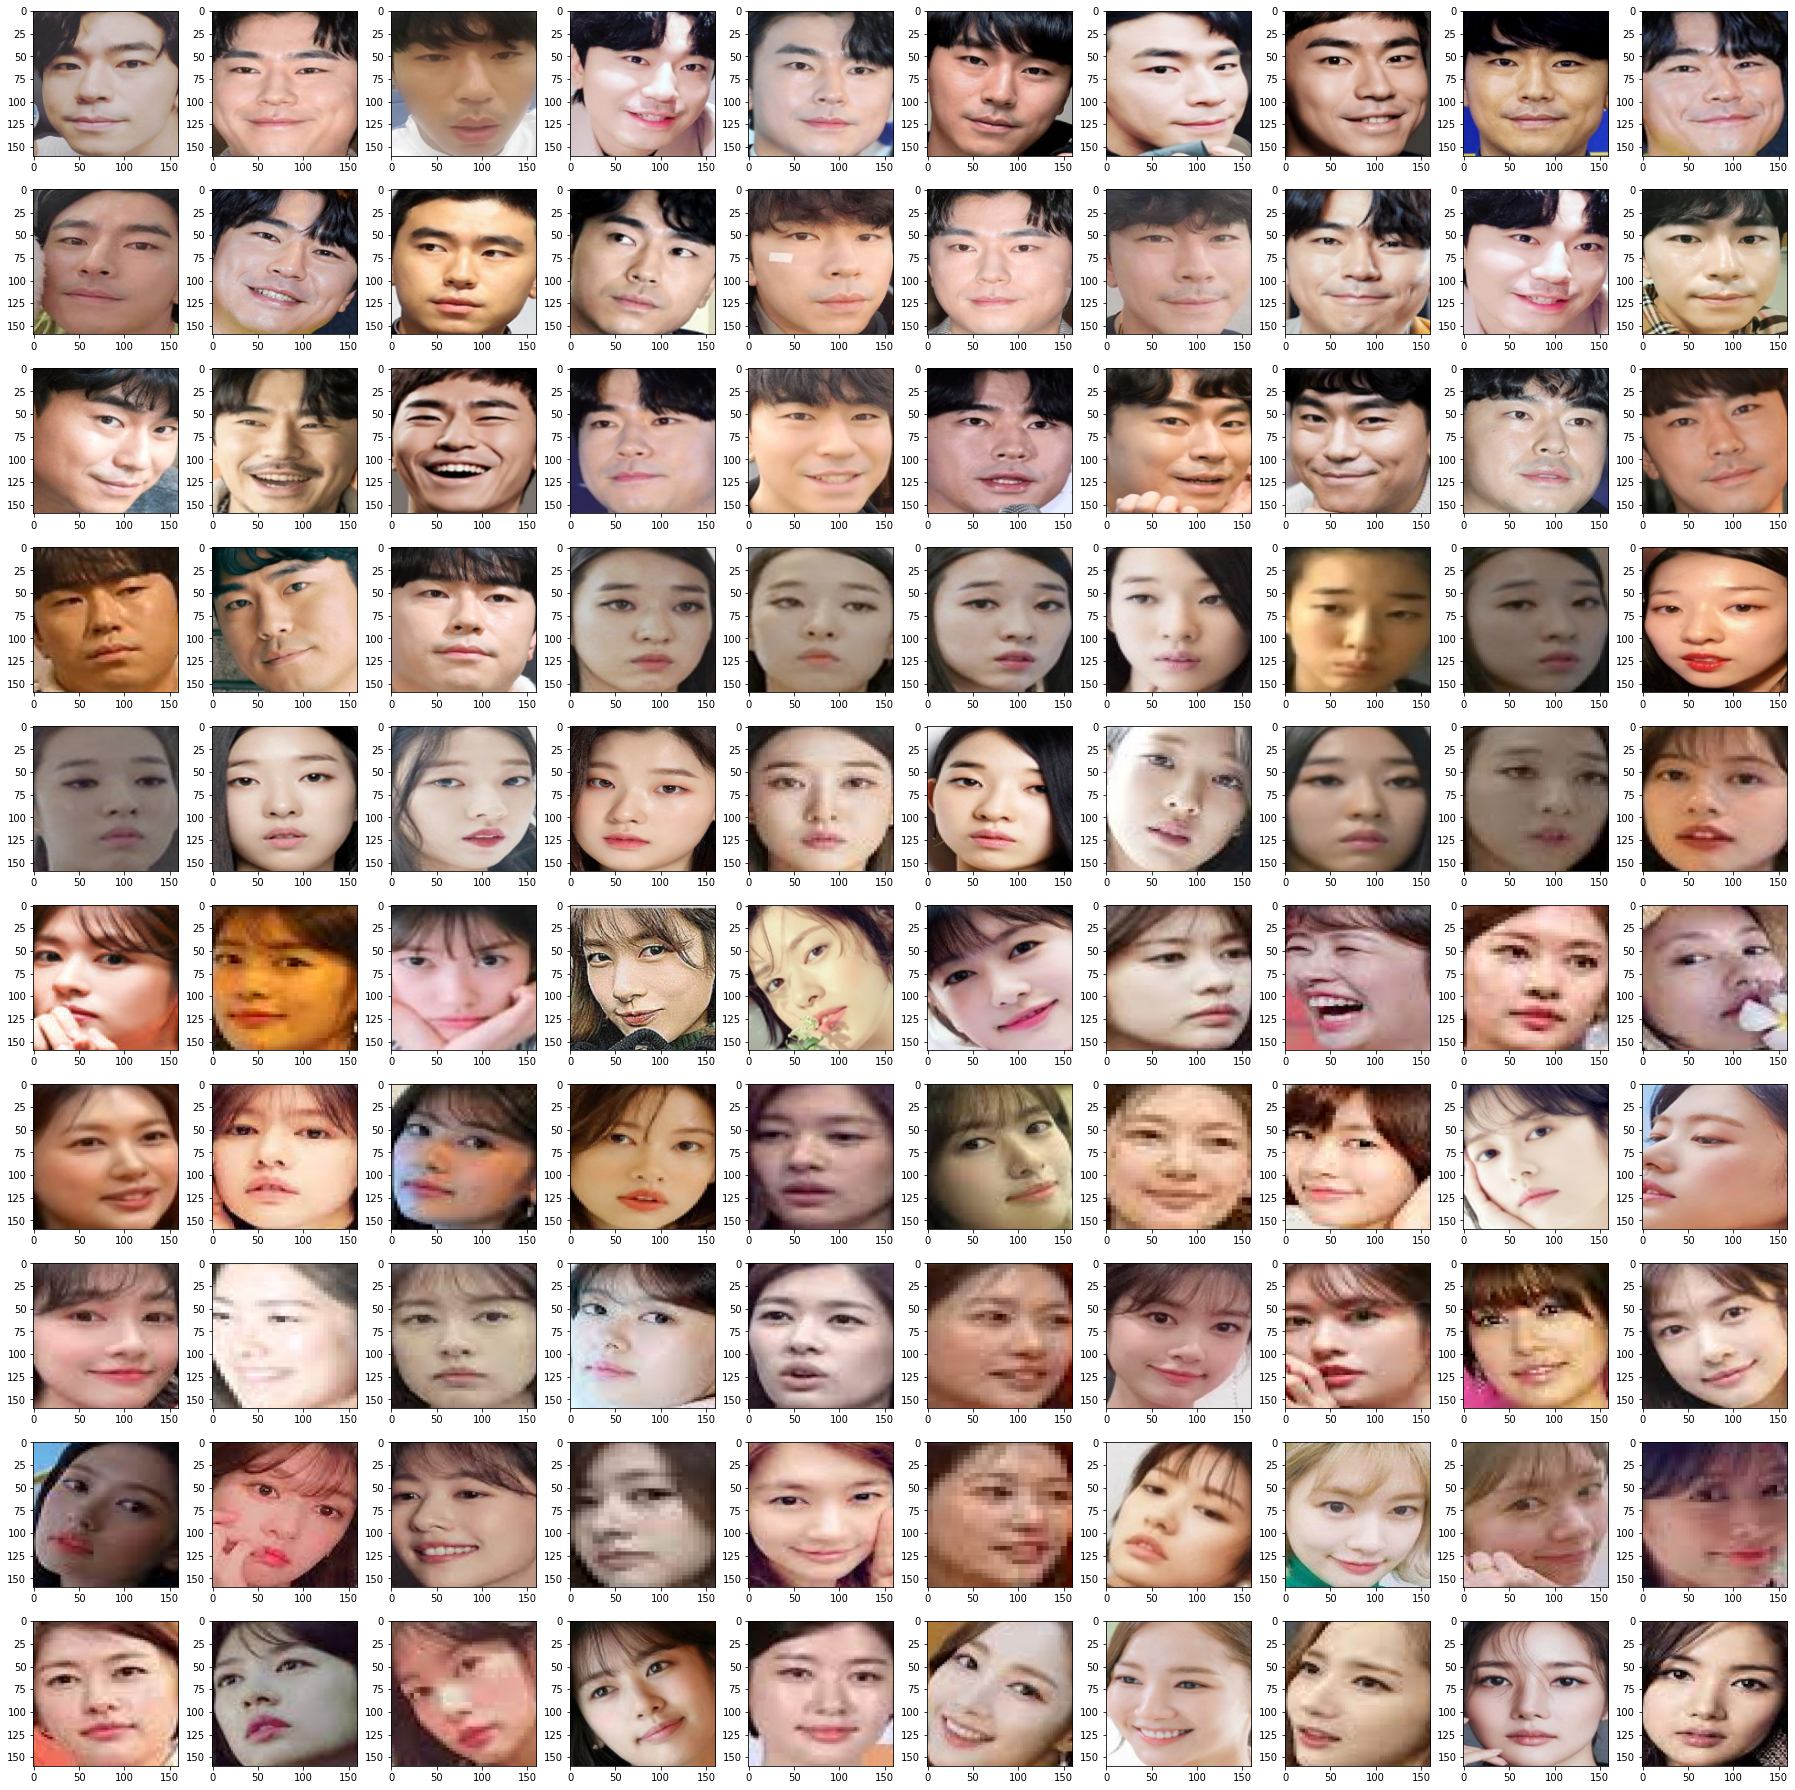

In [12]:
row_size = 10
col_size = min(10, math.ceil(len(aligned)//row_size))
fig, ax = plt.subplots(row_size, col_size, figsize=(25, 25)) 
for i, output in enumerate(aligned[:100]):
    ax[i//row_size][i%col_size].imshow((output * 128 + 127.5).cpu().numpy().astype(np.Uint64).transpose((1,2,0)))

fig.tight_layout()
plt.show()

### 5. Embedding vector 계산을 위한 Dataset정의 및 데이터로드

In [13]:
class EmbeddingDataset(Dataset):
    def __init__(self, aligned: list):
        aligned_torch = torch.stack(aligned)
        self.aligned_torch = aligned_torch

    def __len__(self):
        return len(self.aligned_torch)

    def __getitem__(self, idx):
        return self.aligned_torch[idx]

In [14]:
aligned_dataset = EmbeddingDataset(aligned)
alinged_loader = DataLoader(aligned_dataset, num_workers=workers, batch_size=50)

In [79]:
print(f'stack된 aligned shape: {aligned_dataset.aligned_torch.shape}') # torch.Size([19708, 3, 160, 160])
print(f'len(aligned_dataset): {len(aligned_dataset)}') # 19708
print(f'len(alinged_loader): {len(alinged_loader)}') # 395

stack된 aligned shape: torch.Size([19708, 3, 160, 160])
len(aligned_dataset): 19708
len(alinged_loader): 395


### 6. InceptionResnetV1 수행

In [17]:
# 19708장 -> 14.5s
embeddings = []
for x in alinged_loader:
    y = resnet(x.to(device))
    embeddings.extend(y.detach().cpu().tolist())

In [18]:
print(f'embedding shape: {np.array(embeddings).shape}')

embedding shape: (19708, 512)
